The objective of the network optimization team is to analyze traces of past activity, which will be used to train an ML system capable of classifying samples of current activity as:
-  **0 (normal)**: current activity corresponds to normal behavior of any working day and. Therefore, no re-configuration or redistribution of resources is needed.
- **1 (unusual)**: current activity slightly differs from the behavior usually observed for that time of the day (e.g. due to a strike, demonstration, sports event, etc.), which should trigger a reconfiguration of the base station. Content: The dataset has been obtained from a real LTE deployment. During two weeks, different metrics were gathered from a set of 10 base stations, each having a different number of cells, every 15 minutes. The dataset is provided in the form of a csv file, where each row corresponds to a sample obtained from one particular cell at a certain time. Each data example contains the following features:
-  **Time** : hour of the day (in the format hh:mm) when the sample was generated.
- **CellName1**: text string used to uniquely identify the cell that generated the current sample. CellName is in the form xαLTE, where x identifies the base station, and α the cell within that base station (see the example in the right figure).
- **PRBUsageUL** and **PRBUsageDL**: level of resource utilization in that cell measured as the portion of Physical Radio Blocks (PRB) that were in use (%) in the previous 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
- **meanThr_DL** and **meanThr_UL**: average carried traffic (in Mbps) during the past 15 minutes. Uplink (UL) and downlink (DL) are measured separately.

- **maxThr_DL** and **maxThr_UL**: maximum carried traffic (in Mbps) measured in the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately. - **meanUE_DL** and **meanUE_UL**: average number of user equipment (UE) devices that were simultaneously active during the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
- **maxUE_DL** and **maxUE_UL**: maximum number of user equipment (UE) devices that were simultaneously active during the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
- **maxUE_UL+DL**: maximum number of user equipment (UE) devices that were active simultaneously in the last 15 minutes, regardless of UL and DL.
- **Unusual**: labels for supervised learning. A value of 0 determines that the sample corresponds to normal operation, a value of 1 identifies unusual behavior.

In [1]:

import pandas as pd



In [2]:
df=pd.read_csv('./ML-MATT-CompetitionQT2021.csv',sep=';')

In [3]:
df.head()

,Time,CellName,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL,maxUE_UL+DL,Unusual
0,10:45,3BLTE,12.3848,1.4019,0.3927,0.0438,16.6522,0.6806,1.1293,1.0491,5,3,8,1
1,9:45,1BLTE,22.0438,2.0016,0.5620,0.2697,10.3994,1.1771,1.4480,1.1630,6,5,11,1
2,7:45,9BLTE,0.5105,0.4258,0.0152,0.0106,0.2755,0.1685,1.0379,1.0535,1,2,3,1
3,2:45,4ALTE,1.9963,1.1513,0.9908,0.0245,64.7465,0.8747,1.0766,1.0526,3,2,5,1
4,3:30,10BLTE,0.3030,0.4040,0.0160,0.0130,0.3480,0.1680,1.0110,1.0110,2,1,3,0


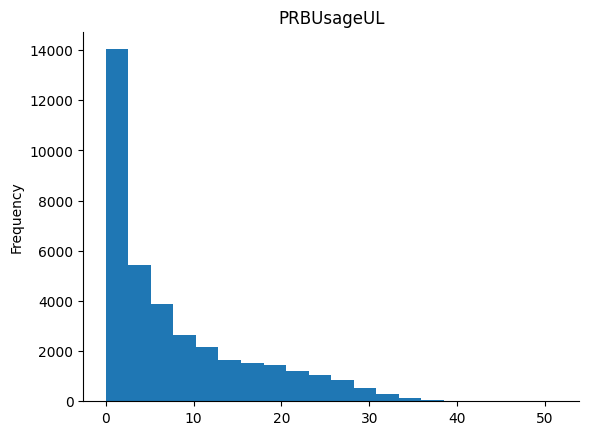

In [4]:
# @title PRBUsageUL

from matplotlib import pyplot as plt
df['PRBUsageUL'].plot(kind='hist', bins=20, title='PRBUsageUL')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [5]:
df_model=df.drop(['CellName','Time'],axis=1)

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_model.drop('Unusual',axis=1), df_model['Unusual'], test_size=0.2, random_state=42)

In [8]:
# Assuming necessary imports (tensorflow, keras models, keras layers) are already present

# Define the autoencoder model
input_dim = X_train.shape[1]
input_layer = Input(shape=(input_dim,), name='input_layer')

# Encoder
encoder_layer1 = Dense(64, activation='relu', name='encoder_layer1')(input_layer)
encoder_layer2 = Dense(32, activation='relu', name='encoder_layer2')(encoder_layer1)
bottleneck_layer = Dense(16, activation='relu', name='bottleneck_layer')(encoder_layer2)

# Decoder
decoder_layer1 = Dense(32, activation='relu', name='decoder_layer1')(bottleneck_layer)
decoder_layer2 = Dense(64, activation='relu', name='decoder_layer2')(decoder_layer1)
output_layer = Dense(input_dim, activation='linear', name='output_layer')(decoder_layer2)

# Create the model
autoencoder = Model(inputs=input_layer, outputs=output_layer, name='autoencoder')

# Display the model summary (optional)
autoencoder.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 11)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_layer1 (Dense)               │ (None, 64)                  │             768 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ encoder_layer2 (Dense)               │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bottleneck_layer (Dense)             │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer1 (Dense)               │ (None, 32)                  │             544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ decoder_layer2 (Dense)               │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 11)                  │             715 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,747 (26.36 KB)

 Trainable params: 6,747 (26.36 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, verbose=0)

# Make predictions on the test set
predictions = autoencoder.predict(X_test)

# Calculate the reconstruction errors (MSE for each sample)
mse = tf.keras.losses.MSE(X_test, predictions)

# Ensure reconstruction errors are a 1D tensor
reconstruction_errors = tf.reshape(mse, [-1])

# Calculate the mean of the reconstruction errors
mean_reconstruction_error = tf.reduce_mean(reconstruction_errors)

# Set the threshold for anomaly detection (lowered)
threshold = mean_reconstruction_error + 2 * tf.math.reduce_std(reconstruction_errors)

# Classify anomalies
y_pred = tf.where(reconstruction_errors > threshold, 1, 0)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

231/231 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.7160
Precision: 0.2549
Recall: 0.0127
F1-Score: 0.0242


In [14]:
print('hi')

hi
